In [1]:
#For downloads
import gdown, os, gzip, shutil

# Basic data management and plotting
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import os

# Scanpy fundamentals
import anndata as ad
import scanpy as sc
import seaborn as sb

# sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(figsize=(6, 6))
import scvi
from scvi.external import SOLO

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


# Frequency analysis

We analyze the frequency of the identified cell types, comparing samples from control and hepatoblastoma (HB) conditions. First, we classify samples into 'control' and 'HB' based on their labels. We then calculate the total number of cells for each sample and determine the count of each cell type within both control and HB groups. By normalizing these counts, we compute the frequency of each cell type as a proportion of the total cells per sample. Finally, we visualize these frequencies using a boxplot to compare the distribution of cell type frequencies between the control and HB conditions.

In [3]:
adata = sc.read_h5ad('/datos/home/jupyter-mdiaz/scRNAseq_pipeline/adata_saved/P5_labelled.h5ad')

In [4]:
adata.obs.Sample.unique().tolist()

['h5ad/control7',
 'h5ad/tumor3',
 'h5ad/control3',
 'h5ad/control4',
 'h5ad/tumor4',
 'h5ad/control6',
 'h5ad/control1',
 'h5ad/tumor1',
 'h5ad/tumor5',
 'h5ad/control5',
 'h5ad/control2',
 'h5ad/tumor2']

In [5]:
def map_condition(x):
    if 'tumor' in x:
        return 'HB'
    else:
        return 'control'

In [6]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

,n_genes,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,cell type,condition
AAACCCAAGATAGTCA-1,2713,h5ad/control7,False,2713,6230.0,0.0,0.0,0,0,4,Hepatocytes,control
AAACCCAAGGTAGACC-1,3518,h5ad/control7,False,3518,9725.0,0.0,0.0,0,0,30,Mast cells,control
AAACCCACACGCACCA-1,3848,h5ad/control7,False,3848,12794.0,0.0,0.0,0,0,4,Hepatocytes,control
AAACCCAGTTCTGACA-1,2350,h5ad/control7,False,2350,4994.0,0.0,0.0,0,0,4,Hepatocytes,control
AAACCCATCCGCCTAT-1,4195,h5ad/control7,False,4195,15739.0,0.0,0.0,0,0,4,Hepatocytes,control
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCATTCATC-1,603,h5ad/tumor2,False,603,825.0,0.0,0.0,0,0,8,Hepatocytes,HB
TTTGTTGTCCGTGGCA-1,2261,h5ad/tumor2,False,2261,3473.0,0.0,0.0,0,0,15,Hepatic stellate cells,HB
TTTGTTGTCCTTGGAA-1,2268,h5ad/tumor2,False,2268,4130.0,0.0,0.0,0,0,14,Hepatic stellate cells,HB
TTTGTTGTCGTCGCTT-1,670,h5ad/tumor2,False,670,894.0,0.0,0.0,0,0,8,Hepatocytes,HB


In [7]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/tmp/ipykernel_3720579/2419454245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['Sample']).count()


{'h5ad/control1': 4533,
 'h5ad/control2': 6475,
 'h5ad/control3': 2332,
 'h5ad/control4': 2776,
 'h5ad/control5': 7359,
 'h5ad/control6': 9167,
 'h5ad/control7': 7462,
 'h5ad/tumor1': 7130,
 'h5ad/tumor2': 16258,
 'h5ad/tumor3': 11012,
 'h5ad/tumor4': 7113,
 'h5ad/tumor5': 10961}

In [8]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:5]]
cell_type_counts

/tmp/ipykernel_3720579/690316385.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()


,Sample,condition,cell type,n_genes,doublet
0,h5ad/control1,control,Cholangiocytes,106,106
1,h5ad/control1,control,Dendritic cells,504,504
2,h5ad/control1,control,Gamma delta T cells,1773,1773
3,h5ad/control1,control,Hepatocytes,1603,1603
4,h5ad/control1,control,Kupffer cells,170,170
...,...,...,...,...,...
98,h5ad/tumor5,HB,Hepatocytes,1046,1046
99,h5ad/tumor5,HB,Mast cells,1284,1284
100,h5ad/tumor5,HB,Monocytes,51,51
101,h5ad/tumor5,HB,NK cells,367,367


In [9]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

,Sample,condition,cell type,n_genes,doublet,total_cells,frequency
0,h5ad/control1,control,Cholangiocytes,106,106,4533,0.023384
1,h5ad/control1,control,Dendritic cells,504,504,4533,0.111185
2,h5ad/control1,control,Gamma delta T cells,1773,1773,4533,0.391132
3,h5ad/control1,control,Hepatocytes,1603,1603,4533,0.353629
4,h5ad/control1,control,Kupffer cells,170,170,4533,0.037503
...,...,...,...,...,...,...,...
98,h5ad/tumor5,HB,Hepatocytes,1046,1046,10961,0.095429
99,h5ad/tumor5,HB,Mast cells,1284,1284,10961,0.117143
100,h5ad/tumor5,HB,Monocytes,51,51,10961,0.004653
101,h5ad/tumor5,HB,NK cells,367,367,10961,0.033482


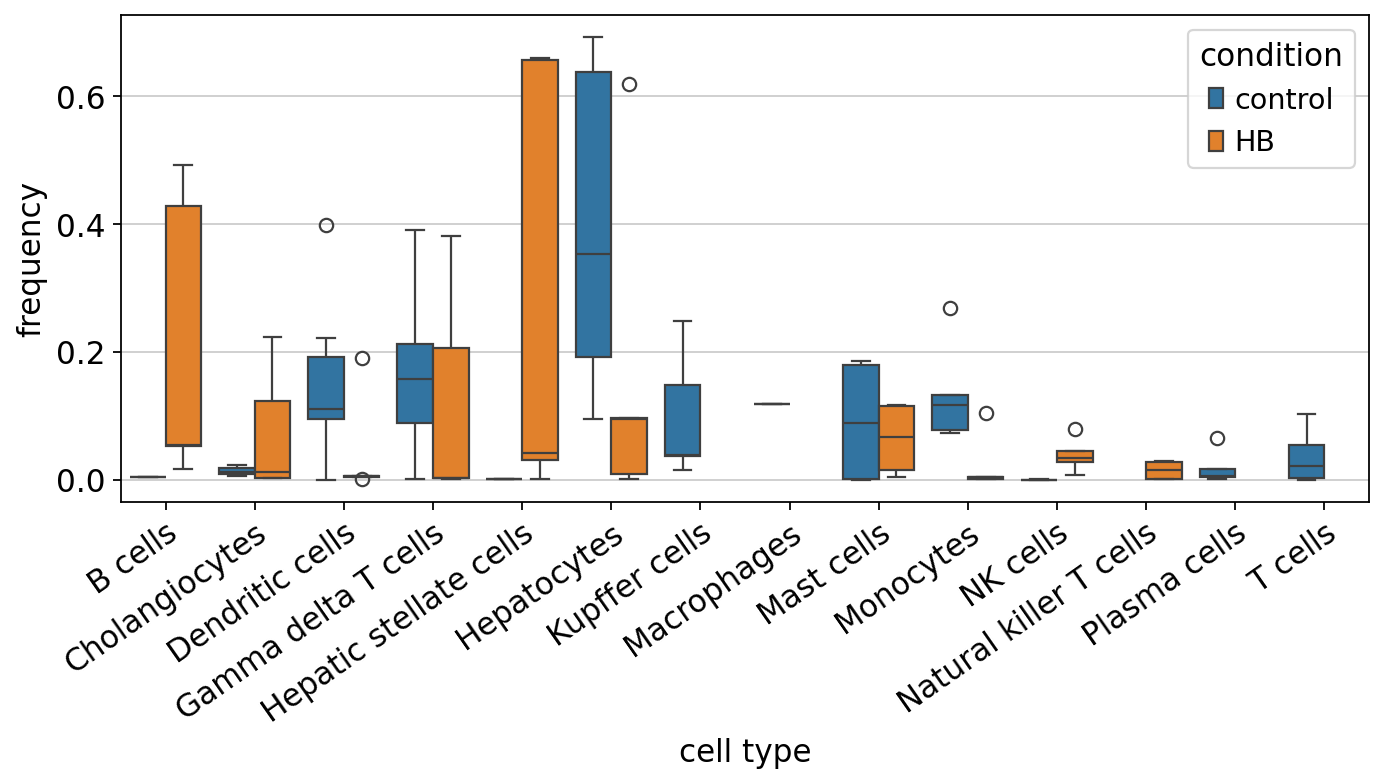

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()


In [11]:
adata.write_h5ad('/datos/home/jupyter-mdiaz/experimento_3/COMPLETO2/adata_saved/P6_count_cells.h5ad')